In [1]:
import easyfsl


해당 라이브러리는 few shot learning을 쉽게 할 수 있게 해주는 파이썬 라이브러리

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

torch nn = 뉴럴 네트워크
optim = 옵티마이저
Data Loader = 데이터로더 작성
torch vision transforms = 데이터 트랜드포머
모델은 레즈넷18 사용
tqdm = 현재 for문 실행 정도 확인

easy fsl, TaskSample = fs learning을 위한 샘플링 기능 제공
plot image, sliding average = 각각 플롯이미지 제공, 시계열 데이터의 슬라이딩 평균 계산


In [3]:
image_size = 28

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


해당 데이터의 input shape 는 28 이후 Resize
channel 1의 데이터지만 해당 모델에서는 3 channel 데이터로 사용. 
centercrop으로 이미지를 중심으로 보내고, 텐서화를 통해 데이터화

Few Shot learning 이란 ? 
Labeled Support set 과 Query set을 갖고있음. Query set의 각각 이미지 데이터에 대해 Support set으로 부터 라벨을 예측하고 싶다. Few Shot learning은 반드시 support set 으로부터 query이미지의 라벨링을 해야하마. 

few shot 은 support set이 매우 적은 라벨당 이미지를 갖고 있는 경우를 말한다 (10이하) 
ex) 3ways 2shot = 3가지 다른 클래스가 각각 2개의 이미지를 갖고 있음. 
해당 모델은 오직 supporting set만을 통해서 훈련되는 모델임.
예를 들어 해당 이미지에서 오른쪽의 query images의 라벨을 예측하기 위해선 왼쪽의 supporting set의 학습만으로 해야한다. 
![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)


대부분의 few shot classification은 행렬베이스.

1)CNN을 사용해 support set , query image 를 feature space로 전환한다.

2)query images를 support images와 비교하여 분류한다.


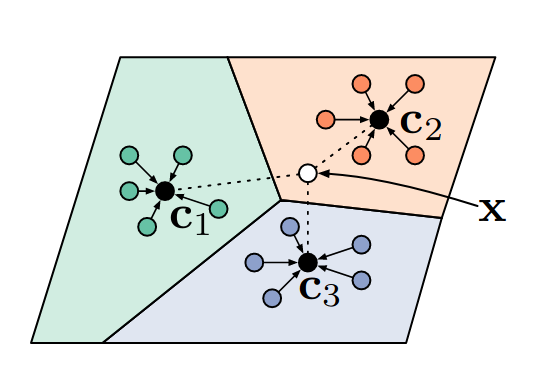
이때 주의할 점 
1. 좋은 Feature space를 찾아야 한다. 이것이 CNN이 하는 역할임. CNN은 기본적으로 이미지를 feature space의 input, output data로 representation ( or embedding )한다. 여기서의 과제는 CNN이 같은 클래스를 훈련하지 않았더라도 서로 가깝게 재표현하는 것이다. 

2. Feature space에서 representations을 비교하기 위해 Prototypical Networks를 사용.

Suppory set에서 Prototypical networks 는 각 클래스의 prototype를 계산한다. 이 클래스의 support images 로부터 나온 임베딩을 뜻한다. 그리고 각각 query는 feature space에서 가장 가까운 prototype을 구하는 방식으로 간단하게 분류된다. PrototypicalNetworks를 구현해보자잇


1. PrototypicalNetworks 클래스를 기반으로 구성. 이것은 feature extractor이다. 그리고 우리는 ImageNet(대규모 이미지 데이터셋) 에서 미리 학습된 Resnet18을 기반. 이후 이 feature를 잘라서 Flatten 레이어에 적용할 수 있도록한다. 그결과 인풋 이미지는 512 차원의 feature vector가 될것이다.
2. forward 방법은 3개의 인풋 텐서를 취한다. Query images의 라벨을 예측하기 때문에 우리는 support images와 라벨들을 모델의 인풋데이터로 사용한다.


In [40]:
class PrototypicalNetworks(nn.Module): #nn모듈에서 가져온 Module을 부모클래스로 상속한다는 의미
    def __init__(self, backbone:nn.Module):  # 생성자 정의, backbone은 생성자 매개변수 - nn.Module타입의 매개변수 정의 즉 인스턴스를 초기화시 반드시 backbone이라는 nn.Module 타입의 매개변수 필요. 
        super(PrototypicalNetworks, self).__init__() #PrototypicalNetworks 가 nn.Module을 상속 했으므로 이줄은 nn.Module클래스를 나타내는 객체를 반환
        self.backbone = backbone #backbone은 특징을 추출하는 하위신경망 
        
    def forward( #forward 함수 설정, 앞으로 어떻게 훈련이 진행되어 갈지
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor, #상기한대로 3가지 인풋값을 사용
    ) ->torch.Tensor:
        """
        query labels를 예측하기 위해 labeled support images 사용
        """
        # support and query images 로부터 feature extrat
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        
        # support set의 labels로부터 각기 다른 클래스의 숫자 정의
        n_way = len(torch.unique(support_labels))
        # prototype i 는 라벨 i에 상응하는 모든 피쳐인스턴스의 평균.
        z_proto = torch.cat(
                [
                    z_support[torch.nonzero(support_labels == label)].mean(0)
                    for label in range(n_way)
                ]
        )
        """
        z_support와 support_labels텐서를 사용하여 z_proto라는 새로운 텐서 생성.
        각각 n_way에 해당하는 클래스를 순회하며 루프를돈다. 각 클래스의 프로토타입 계산
        z_support 텐서에서 support_labels과 label이 일치하는 인덱스를 찾아서 해당 클래스에 대해
        데이터 포인터들을 선택하고, 선택한 포인트 들의 평균을 계산하여 해당 클래스의 프로토타입
        벡터를 얻음. 각 클래스에 대한 프로토 타입 벡터를 하나로 합쳐서 z_proto 텐서를 생성.
        """
        # querise 와 prototypes의 유클리드 거리를 계산.
        dists = torch.cdist(z_query, z_proto)
        
        #그리고 이런 거리를 분류 스코어로 재계산
        scores = -dists
        return scores

# resnet18로 CNN네트워크 설정. 이미 학습됨.
convolutional_network = resnet18(pretrained=True)
# CNN네트워크의 fc부분을 nn.Flatten()으로 적용하겠다
convolutional_network.fc = nn.Flatten()

print(convolutional_network)
#해당 CNN을 기반으로 PorototypicalNetworks 구현
model = PrototypicalNetworks(convolutional_network).cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

사전학습된 feature extractor를 사용한다. 여기서 만드는 Dataloaer는 few shot classification임무에 사용될 것 이다. 하지만 일반적으로 파이토치의 데이터로더는 배치당 이미지를 부여한다. 이들의 라벨이 support set인지 query set인지 고려하지 않음. 

1. 주어진 클래스 만큼 균등하게 분류된 이미지가 필요하다.
2. 우리는 이것을 support 와 query셋으로 나눠야함. 

첫 번째, 맞춤형 샘플러 작성. n_way클래스를 샘플링, 각 클래스에 대해 n_shot + n_query 이미지를 샘플링 한다. 각배치의 총 n_way * (n_shot + n_query) 개의 이미지가 갖고있음 
두 번째, 내장된 pytorch collate 함수를 대체해 맞춤형으로 사용한다. 이건 각각의 배치에 5개의 조합된 아이템을 사용한다. collate 함수는 batch에서 나오는 데이터의 출력 형태를 정해주는 parameter.

1. support images
2. support labels between 0 and n_way
3. query images
4. query labels between 0 and n_way
5. 범위안에 있는 데이터를 실제 클래스 iD에 매핑한다. 

데이터 로더는 샘플러의 조합과 같다. 데이터셋과 collate 함수: 샘플러는 어떤 아이템을 가져올지 알려주고, 데이터셋은 어떻게 가져올지 알려주고, 콜레이트 함수는 어떻게 아이템을 나타낼지 알려줌. 

In [31]:
N_WAY = 5 # 임무에 들어있는 클래스의 숫자
N_SHOT = 5 # Support set의 클래스마다 있는 이미지의 숫자
N_QUERY = 10 # Query set의 클래스마다 있는 이미지의 숫자
N_EVALUATION_TASKS = 100

# 샘플러는 데이터셋과 get_labels가 필요하다.
# def get_labels():
#     return [instance[1] for instance in test_set._flat_character_images]


test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
# 아마도.. instance라는 배열의 두번째 를 대상으로 실행되는 함수. instance는 test_set._flat_character_images 로부터 오는것
test_set.get_labels = get_labels

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    #num_workers=3,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


In [32]:
test_set.get_labels

<function __main__.get_labels()>

DataLoader (
        batch_size : 지정한 batch값에따라 데이터를 나누어서 변환,
        
        shuffle : 데이터를 섞어서 사용할 것인가의 여부,
        
        sampler : 데이터 인덱스를 다루는 방법. 인덱스를 직접 다루기 때문에, shuffle이 False여야 사용할 수 있음.
        
        불균형 데이터셋의 경우 클래스의 비율에 맞게 데이터를 제공해야할 필요가 있다. 이때 사용 가능.
        1) SequentialSampler : 항상 같은 순서로
        2) RandomSampler : 랜덤, replacement 여부 선택, 개수 선택 가능
        3) SubsetRandomSampler : 랜덤 리스트,
        4) WeightRandomSampler : 가충치에 따른 확률
        5) BatchSampler = batch단위로 sampling,
        6) DistributedSampler : 분산처리
        num_workers = 데이터를 불러올 때 사용하는 서브 프로세스의 개수, num_works 높다고 좋은 것 X, 병목현상 가능성. ( parameter tune )
        collate_fn : 미니 배치를 생성하기 위해 샘플 리스트를 병합하는 역할.
        zero_padding이나 variable-size 등 데이터 사이즈를 맞추기 위해 함수를 만들어 적용.
        ((피쳐1,라벨1),(피처2,라벨2)) -> ((피처1,피처2),(라벨1,라벨2) 
        )
        
        pin_memory : True로 설정시, tensor를 CUDA 고정 메모리에 할당. 고정 된 메모리에서 데이터를 가져오므로 훨씬 빠르다. but 일반적으론 사용 x 왜?


우리는 5ways-5shot tasks 를 부여하는 데이터로더를 생성하였다. 


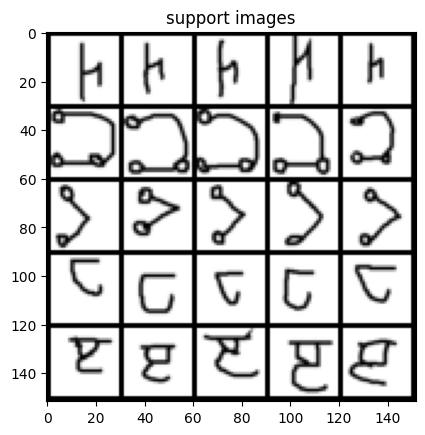

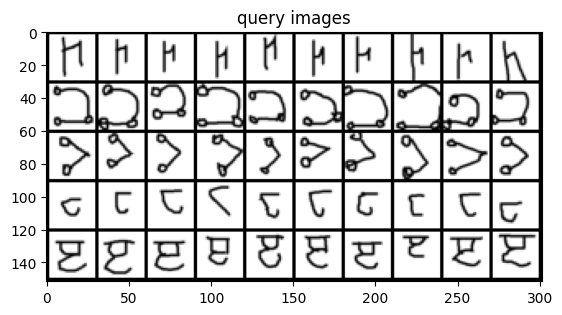

In [33]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

두개의 support와 query 셋을 통해서, 각 클래스에 대해 한개의 라인을 가져야함 .

그렇다면 우리의 모델은 해당 task에서 어떻게 실행될까?

In [46]:
model.eval() #모델을 수정 없이 그대로 실행
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

yes = 0
no = 0

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )
    if test_set._characters[example_class_ids[example_query_labels[i]]] == test_set._characters[example_class_ids[example_predicted_labels[i]]]:
        yes += 1;
    else:
        no += 1;
print(yes,no)

Ground Truth / Predicted
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Atemayar_Qelisayer\character20 / Atemayar_Qelisayer\character20
Angelic\character02 / Angelic\character02
Angelic\character02 / Angelic\character02
Angelic\character02 / Angelic\character02
Angelic\character02 / Angelic\character02
Angelic\character02 / Angelic\character02
Angelic\character02 / Angelic\character02
Angelic\character02 / Angelic\character02
Angelic\character02 / Angelic\character02

모델 평가 모델에 대해서 만들어 보겠음

In [55]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    정확한 예측수, 총 예측 결과 수 두가지 반환
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)
# torch.max(... 1,)[1] : 텐서의 각 행에서 최대값과 그 위치(인덱스)를 찾는다. [1]는 최대값의 위치(인덱스)를 반환한다.
# model(....detach().data) : 그래프 연산을 분리하고 데이터 텐서를 추출, 예측 결과의 역전파가 비활성화됨, 예측 결과값만 반환.
# == query_labels.cuda() : support labels 과 query labels와 비교하여 나타내는 부울 텐서 도출
# .sum().item() : True 값의 데이터 합계 계산 , item()으로 정수로 변환
#


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval 모드는 batch norm , droput layer에 영향을 준다.
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.65it/s]

Model tested on 100 tasks. Accuracy: 86.46%


우리는 완벽히 Omniglot images에 대해 제로 트레이닝을 진행했음 , 그리고 각 클래스당 5개의 예시들을 갖고있다. 
그리고 prototypical Networks가 어떻게 일을 하는지 파악해볼 것. 

약간의 변화를 주고 추후 관찰 ( change backbone , use other distances than euclidean..)

문제에도 변화를 줄 수 있음 ( more classes in each task, less or more exmaples in the support set 혹은 한개의 예시만.)

이것을 통해서 어떻게 Meta train this model 에대해 이해할 수 있음 ! 

# Training a meta-learning algorithm

Omniglot의 "background" 이미지들을 트레인 셋으로 사용해보자. 여기 40000개의 데이터로더로  few shot classification tasks 우리의 모델을 학습시킬것임.훈련 세트에 사용된 알파벳은 테스트 세트에 사용된 알파벳과 완전히 분리. 이렇게 하면 테스트 시 모델이 훈련 중에 보지 못한 문자를 분류해야 한다.

In [56]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    #num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

같은모델사용, 우리의 가중치는 ImaageNet으로부터 pre-trained 상태. 만약 스스로 따로 학습시키고 싶다면 pretrained = False로 설정.
계속해서 loss 펑션과 옵티마이저를 설정할것이다. ( CA, Adam ).그리고 fit함수를 만드는데, 이매서드는 분류테스크를 인풋으로 사용한다. support set and query set. support set의 정보를 기반으로 query set의 라벨을 예측한다. 그리고 예측라벨과 문의라벨의 비교, loss값을 반환. 그리고 해당 로스값을 통해 모델의 파라미터를 업데이트한다. - meta training loop.

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

모델을 훈련하기 위해 무작위로 생성된 많은 수의 소수 샷 분류 작업을 반복하고 각 작업 후에 적합 방법이 모델을 업데이트한다. 이를 에피소드 트레이닝이라 부름.

In [59]:

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  4%|██▋                                                            | 1680/40000 [04:42<1:47:14,  5.96it/s, loss=0.954]


KeyboardInterrupt: 

model.train(): PyTorch 모델을 훈련 모드로 설정합니다. 이 명령은 모델 내부에서 드롭아웃(dropout) 또는 배치 정규화(batch normalization)와 같은 학습 관련 작업을 활성화합니다.

with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:: tqdm 라이브러리를 사용하여 훈련 진행 상황을 시각적으로 표시하는 루프를 시작합니다. enumerate(train_loader)는 데이터 로더(train_loader)에서 에피소드(훈련 반복)를 열거하는 반복자(iterator)를 생성하고, total=len(train_loader)는 총 반복 횟수를 지정합니다.

tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency)): tqdm 라이브러리의 set_postfix 메서드를 사용하여 현재 진행 상황에 대한 정보를 업데이트합니다. 이 경우 loss 정보를 업데이트하고, sliding_average 함수를 사용하여 최근 log_update_frequency번의 손실 값을 평균화하여 보여줍니다.

In [60]:
!wget https://public-sicara.s3.eu-central-1.amazonaws.com/easy-fsl/resnet18_with_pretraining.tar
model.load_state_dict(torch.load("resnet18_with_pretraining.tar", map_location="cuda"))

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


FileNotFoundError: [Errno 2] No such file or directory: 'resnet18_with_pretraining.tar'

해당 모델을 사용해서 학습하면 98%정도의 결과값이 나오지만, 이미지넷 기반으로만 학습된 것에 대한 결과보다 Omniglot 이미지를 직접적으로 학습해서 높은 결과값이 나오는 건 일반적인 상황. 그러나 우리가 예측한 데이터들은 학습동안 보여지지 않은 데이터라는 것을 인지해야함. 


# 무엇을 배웠는지?
- prototypical Network의 원리 이해 및 구현 
- Omnigolt 데이터 사용, few shot model의 성능 평가
- few shot 분류테스크의 폼에서 sample batch를 어떻게 코스텀하는지
- metalearning 방법과 few shot algorithm 사용 

## What's next?

- Take this notebook in your own hands, tweak everything that there is to tweak. It's the best way to understand what does what.
- Implement other few-shot learning methods, such as Matching Networks, Relation Networks, MAML...
- Try other ways of training. Episodic training is not the only way to train a model to generalize to new classes!
- Experiment on other, more challenging few-shot learning benchmarks, such as [CUB](http://www.vision.caltech.edu/visipedia/CUB-200.html)
or [Meta-Dataset](https://github.com/google-research/meta-dataset).
- If you liked this tutorial, feel free to ⭐ [give us a star on Github](https://github.com/sicara/easy-few-shot-learning) ⭐
- **Contribute!** The companion repository of this notebook is meant to become a boilerplate, a source of useful code that
that newcomers can use to start their few-shot learning projects.